## Semantic Role Labelling with BERT (~3 hours)

The goal of this notebook is to train and evaluate a semantic role labeling (SRL) system. For each input token (word), the system will predict a B-I-O tag and a predicate, as illustrated in the following example:

</br>



|The|judge|scheduled|to|preside|over|his|trial|was|removed|from|the|case|today|.|             
|---|-----|---------|--|-------|----|---|-----|---|-------|----|---|----|-----|-|             
|B-ARG1|I-ARG1|B-V|B-ARG2|I-ARG2|I-ARG2|I-ARG2|I-ARG2|O|O|O|O|O|O|O|

BIO = Beginning, Inside, and Outside
Arg1 = causer, Arg2 = effect, amount of effect<br/>



The SRL system will be implemented in [PyTorch](https://pytorch.org/). We will fine-tune the pretrained BERT model on the SRL task.




---


For first-time BERT users, try this Google notebook to understand the basics: https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb


---



### What is BERT?

- BERT is pre-trained using 64 TPUs over 4 days
- BERT is a MLM (Masked Language Model) — masking a word in a sentence and forcing bidirectional token prediction
- Transformer-based architecture

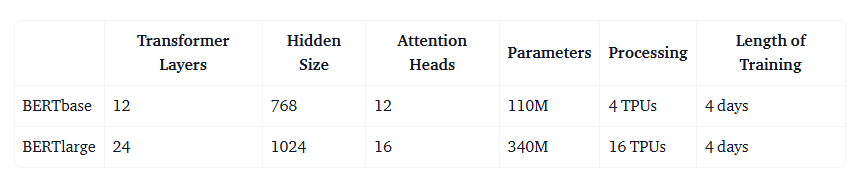


## Steps to Finetune: (<1 min)


1. Encode the sentence with BERT
2. Generate (contextualized) embedding
3. Feed embeddings into classifier to predict tag




Recall that BERT is trained on two input sentences, seperated by [SEP], and on a next-sentence-prediction objective (in addition to the masked LM objective). To help BERT comprehend which sentence a given token belongs to, the original BERT uses a segment embedding, using A for the first sentene, and B for the second sentence 2.
Because we are labeling only a single sentence at a time, we can use the segment embeddings to indicate the predicate position instead: The predicate is labeled as segment B (1) and all other tokens will be labeled as segment A (0).

<img src="https://github.com/daniel-bauer/4705-f23-hw5/blob/main/bert_srl_model.png?raw=true" width=400px>

## Setup: GCP, Jupyter, PyTorch, GPU (<1 min)

To make sure that PyTorch is available and can use the GPU, run the following cell which should return True. If it doesn't, make sure the GPU drivers and CUDA are installed correctly.

GPU support is required for this notebook -- you will not be able to finetune BERT on a CPU.

In [36]:
import torch
torch.cuda.is_available()

True

## Dataset: Ontonotes 5.0 English SRL annotations (5 mins)

Download the data:

In [37]:
! wget https://storage.googleapis.com/4705-bert-srl-data/ontonotes_srl.zip

--2025-02-11 07:04:16--  https://storage.googleapis.com/4705-bert-srl-data/ontonotes_srl.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 74.125.126.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12369688 (12M) [application/zip]
Saving to: ‘ontonotes_srl.zip.1’

ontonotes_srl.zip.1 100%[===================>]  11.80M  44.4MB/s    in 0.3s    

2025-02-11 07:04:16 (44.4 MB/s) - ‘ontonotes_srl.zip.1’ saved [12369688/12369688]



In [ ]:
! unzip ontonotes_srl.zip

Archive:  ontonotes_srl.zip
  inflating: propbank_dev.tsv        
  inflating: propbank_test.tsv       
  inflating: propbank_train.tsv      
  inflating: role_list.txt           


We have now downloaded the four files:
1. propbank_dev.tsv
2. propbank_test.tsv
3. propbank_train.tsv
4. role_list.txt

The data has been pre-processed in the following format. There are three files:

`propbank_dev.tsv`	`propbank_test.tsv`	`propbank_train.tsv`

Each of these files is in a tab-separated value format. A single predicate/argument structure annotation consists of four rows. For example

```
ontonotes/bc/cnn/00/cnn_0000.152.1
The     judge   scheduled       to      preside over    his     trial   was     removed from    the     case    today   /.
                schedule.01
B-ARG1  I-ARG1  B-V     B-ARG2  I-ARG2  I-ARG2  I-ARG2  I-ARG2  O       O       O       O       O       O       O
```

* The first row is a unique identifier (1st annotation of the 152nd sentence in the file ontonotes/bc/cnn/00/cnn_0000).
* The second row contains the tokens of the sentence (tab-separated).
* The third row contains the probank frame name for the predicate (empty field for all other tokens).
* The fourth row contains the B-I-O tag for each token.

The file `rolelist.txt` contains a list of propbank BIO labels in the dataset (i.e. possible output tokens). This list has been filtered to contain only roles that appeared more than 1000 times in the training data.
We will load this list and create mappings from numeric ids to BIO tags and back.

In [38]:
role_to_id = {}
with open("role_list.txt",'r') as f:
    role_list = [x.strip() for x in f.readlines()]
    role_to_id = dict((role, index) for (index, role) in enumerate(role_list))
    role_to_id['[PAD]'] = -100

    id_to_role = dict((index, role) for (role, index) in role_to_id.items())


Note that we are also mapping the '[PAD]' token to the value -100. This allows the loss function to ignore these tokens during training.

## Part 1 - Data Preparation (20 mins)

Before you can build the SRL model, you first need to preprocess the data.


### 1.1 - Tokenization (1 min)

One challenge is that the pre-trained BERT model uses subword ("WordPiece") tokenization, but the Ontonotes data does not. Fortunately Huggingface transformers provides a tokenizer.

In [39]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer.tokenize("This is an unbelievably boring test sentence.")

['this',
 'is',
 'an',
 'un',
 '##bel',
 '##ie',
 '##va',
 '##bly',
 'boring',
 'test',
 'sentence',
 '.']

To demonstrate what the post-trained BERT model will need as inputs, I will show an example.

The following function takes a list of tokens and a list of B-I-O labels of the same length as parameters, and returns a new token / label pair.


```
>>> tokenize_with_labels("the fancyful penguin devoured yummy fish .".split(), "B-ARG0 I-ARG0 I-ARG0 B-V B-ARG1 I-ARG1 O".split(), tokenizer)
(['the',
  'fancy',
  '##ful',
  'penguin',
  'dev',
  '##oured',
  'yu',
  '##mmy',
  'fish',
  '.'],
 ['B-ARG0',
  'I-ARG0',
  'I-ARG0',
  'I-ARG0',
  'B-V',
  'I-V',
  'B-ARG1',
  'I-ARG1',
  'I-ARG1',
  'O'])

```
1. Iterate through each word in sentence
2. Invoke tokenizer
3. return tokenized sentence


In [40]:
def tokenize_with_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces.

    Args:
        sentence: List of words
        text_labels: List of B-I-O labels for each word
        tokenizer: BERT tokenizer

    Returns:
        tokenized_sentence: List of subword tokens
        labels: List of B-I-O labels matching the subword tokens
    """

    tokenized_sentence = []
    labels = []

    # todo
    for word, label in zip(sentence, text_labels):
      # use tokenizer to tokenize
      word_tokens = tokenizer.tokenize(word)
      tokenized_sentence.extend(word_tokens)  # concatenate a list
      # handle subword
      if len(word_tokens) > 0:
        # First subword gets the original label
        labels.append(label)

        # If label starts with B-, remaining subwords get I- prefix
        # nested len(word_tokens) to avoid generating multiple B- tokens
        if len(word_tokens) > 1:
          if label.startswith('B-'):
              base_label = 'I-' + label[2:]  # Convert B- to I- for same role
          else:
              base_label = label  # Keep I- or O as is
          # Add the label for each additional subword
          labels.extend([base_label] * (len(word_tokens) - 1))


    return tokenized_sentence, labels

In [41]:
tokenize_with_labels("the fancyful penguin devoured yummy fish .".split(), "B-ARG0 I-ARG0 I-ARG0 B-V B-ARG1 I-ARG1 O".split(), tokenizer)

(['the',
  'fancy',
  '##ful',
  'penguin',
  'dev',
  '##oured',
  'yu',
  '##mmy',
  'fish',
  '.'],
 ['B-ARG0',
  'I-ARG0',
  'I-ARG0',
  'I-ARG0',
  'B-V',
  'I-V',
  'B-ARG1',
  'I-ARG1',
  'I-ARG1',
  'O'])

### 1.2 Loading the Dataset (10 mins)

Next, we are creating a PyTorch [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class. This class acts as a contained for the training, development, and testing data in memory. For each annotation you start with  the tokens in the sentence, and the BIO tags.

1. call the `tokenize_with_labels` function to tokenize the sentence.
2. Add the (token, label) pair to the self.items list.

\_\_len\_\_(self) method that returns the total number of items.

\_\_getitem\_\_(self, k) method that returns a single item in a format BERT will understand.

We will return a dictionary in the following format:

```
{'ids': token_tensor,
 'targets': tag_tensor,
 'mask': attention_mask_tensor,
 'pred': predicate_indicator_tensor}
```


In [42]:
from torch.utils.data import Dataset, DataLoader

class SrlData(Dataset):

    def __init__(self, filename):

        super(SrlData, self).__init__()

        self.max_len = 128 # the max number of tokens inputted to the transformer.

        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

        self.items = []
        '''
        todo:
            read in data specified by filename
            1. call the `tokenize_with_labels` function to tokenize the sentence.
            2. Add the (token, label) pair to the self.items list.
        '''
        with open(filename, 'r') as f:
            lines = f.readlines()

            # Process 4 lines at a time (format of the data file) Check Dataset data description for more info.
            for i in range(0, len(lines), 4):
                # Skip if we don't have complete 4 lines
                if i + 3 >= len(lines):
                    break

                # Get each line
                # file id, sentence token, predicate information, BIO tags
                sentence = lines[i + 1].strip().split('\t')  # tokens
                predicates = lines[i + 2].strip().split('\t')  # predicate info
                labels = lines[i + 3].strip().split('\t')  # BIO tags

                # Tokenize
                tokenized_sentence, tokenized_labels = tokenize_with_labels(
                    sentence, labels, self.tokenizer
                )

                # Add to items list
                # self.items.append({
                #     'tokens': tokenized_sentence,
                #     'labels': tokenized_labels,
                #     'predicates': predicates
                # })
                self.items.append({
                    'tokens': tokenized_sentence,
                    'labels': tokenized_labels
                })
        # end of init

    def __len__(self):
        # return the total number of items
        return len(self.items)

    def __getitem__(self, k):
        # return a single item in a BERT format
        '''
        * We need to process the sentence by adding '[CLS]'" as the first token and '[SEP]' as the last token. The need to pad the token sequence to 128 tokens using the "[PAD]" symbol.
        This needs to happen both for the inputs (sentence token sequence) and outputs (BIO tag sequence).

        * We need to create an *attention mask*, which is a sequence of 128 tokens indicating the actual input symbols (as a 1) and \[PAD\] symbols (as a 0).
        * We need to create a *predicate indicator* mask, which is a sequence of 128 tokens with at most one 1, in the position of the "B-V" tag.
        All other entries should be 0. The model will use this information to understand where the predicate is located.

        * Finally, we need to convert the token and tag sequence into numeric indices. For the tokens, this can be done using the `tokenizer.convert_tokens_to_ids` method.
        For the tags, use the `role_to_id` dictionary.
        Each sequence must be a pytorch tensor of shape (1,128). You can convert a list of integer values like this `torch.tensor(token_ids, dtype=torch.long)`.
        '''
        item = self.items[k]
        tokens = item['tokens']
        labels = item['labels']

        # Truncate if longer than max_len - 2 (to account for [CLS] and [SEP])
        max_seq_length = self.max_len - 2
        tokens = tokens[:max_seq_length]
        labels = labels[:max_seq_length]


        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        labels = ['O'] + labels + ['O']  # Using 'O' for special tokens
        attention_mask = [1] * len(tokens) # (1 for real tokens, 0 for padding)

        # Pad sequences to exact length
        padding_length = self.max_len - len(tokens)
        if padding_length > 0:
            tokens = tokens + ['[PAD]'] * padding_length
            labels = labels + ['[PAD]'] * padding_length
            attention_mask = attention_mask + [0] * padding_length

        # Convert tokens to ids
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Create predicate indicator
        predicate_mask = [1 if label == 'B-V' else 0 for label in labels]

        # Convert labels to ids
        label_ids = [role_to_id[label] if label in role_to_id else role_to_id['[PAD]'] for label in labels]


        # Convert to tensors
        return {
            'ids': torch.tensor(token_ids, dtype=torch.long),
            'mask': torch.tensor(attention_mask, dtype=torch.long),
            'targets': torch.tensor(label_ids, dtype=torch.long),
            'pred': torch.tensor(predicate_mask, dtype=torch.long)
        }


In [ ]:
# Reading the training data usually takes 10 mins, entire data is preprocessed offline
data = SrlData("propbank_train.tsv")

## 2. Model Definition (10 mins)

In [ ]:
from torch.nn import Module, Linear, CrossEntropyLoss
from transformers import BertModel

Since we will use the BERT model, we define layers and forward function ourselves.

1. Freeze BERT parameters
2. Define linear classifier
3. Classify the tags we created


Module, Linear, and Loss calculation functions are all imported from the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class.

In [ ]:
class SrlModel(Module):

    def __init__(self):

        super(SrlModel, self).__init__()

        self.encoder = BertModel.from_pretrained("bert-base-uncased")

        # The following two lines would freeze the BERT parameters and allow us to train the classifier by itself.
        # We are fine-tuning the model, so you can leave this commented out!
        # for param in self.encoder.parameters():
        #    param.requires_grad = False

        # The linear classifier head, see model figure in the introduction.
        self.classifier = Linear(768, len(role_to_id))


    def forward(self, input_ids, attn_mask, pred_indicator):

        # This defines the flow of data through the model

        # Note the use of the "token type ids" which represents the segment encoding explained in the introduction.
        # In our segment encoding, 1 indicates the predicate, and 0 indicates everything else.
        bert_output =  self.encoder(input_ids=input_ids, attention_mask=attn_mask, token_type_ids=pred_indicator)

        enc_tokens = bert_output[0] # the result of encoding the input with BERT
        logits = self.classifier(enc_tokens) #feed into the classification layer to produce scores for each tag.

        # Note that we are only interested in the argmax for each token, so we do not have to normalize
        # to a probability distribution using softmax. The CrossEntropyLoss loss function takes this into account.
        # It essentially computes the softmax first and then computes the negative log-likelihood for the target classes.
        return logits

### Create new model and store weights in GPU memory (5 mins)

In [ ]:
model = SrlModel().to('cuda') # create new model and store weights in GPU memory

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

#### View a subset of the post-processed items in the Dataset (optional)

In [ ]:
sample = data[0]  # Get first item
# Move tensors to GPU
ids = sample['ids'].unsqueeze(0).to('cuda')  # Add batch dimension
mask = sample['mask'].unsqueeze(0).to('cuda')
pred = sample['pred'].unsqueeze(0).to('cuda')
targets = sample['targets'].unsqueeze(0).to('cuda')
outputs = model(ids, mask, pred)

In [ ]:
print("ids shape:", ids.shape)
print("mask shape:", mask.shape)
print("pred shape:", pred.shape)

for i in range(0, 1): # view a subset of n items in the dataset
   print(data[i])

ids shape: torch.Size([1, 128])
mask shape: torch.Size([1, 128])
pred shape: torch.Size([1, 128])
{'ids': tensor([  101,  2057, 26438,  2135, 13260,  2017,  2000,  3422,  1037,  2569,
         3179,  1997,  2408,  2859,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 



---


Loss functions are very important in understanding how accurate our predictions are, or how good our models are.

-

Without training we would assume that all labels for each token (including the target label) are equally likely, so the negative log probability for the targets should be approximately: $$-\ln(\frac{1}{\text{num_labels}})$$

In [ ]:
import math
-math.log(1 / len(role_to_id), math.e)

3.970291913552122

In [ ]:
loss_function = CrossEntropyLoss(ignore_index = -100, reduction='mean')
loss = loss_function(outputs.transpose(2,1), targets)
print(f"Initial loss: {loss.item()}")

Initial loss: 3.8571228981018066


As we can see, the pre-training prediction score is 3.97 and the actual calculated loss function is not far from it: it is 4.06. We will revisit this score after we train the model.

In the training step, we "teach" the model to do the following:

Take a tensor
```
tensor([[ 1,  4,  4,  4,  4,  4,  5, 29, 29, 29,  4, 28,  6, 32, 32, 32, 32, 32,
         32, 32, 30, 30, 32, 30, 32,  4, 32, 32, 30,  4, 49,  4, 49, 32, 30,  4,
         32,  4, 32, 32,  4,  2,  4,  4, 32,  4, 32, 32, 32, 32, 30, 32, 32, 30,
         32,  4,  4, 49,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  6,  6, 32, 32,
         30, 32, 32, 32, 32, 32, 30, 30, 30, 32, 30, 49, 49, 32, 32, 30,  4,  4,
          4,  4, 29,  4,  4,  4,  4,  4,  4, 32,  4,  4,  4, 32,  4, 30,  4, 32,
         30,  4, 32,  4,  4,  4,  4,  4, 32,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4]], device='cuda:0')
```

Then use the id_to_role dictionary to decode to actual labels.

```
['[CLS]', 'O', 'O', 'O', 'O', 'O', 'B-ARG0', 'I-ARG0', 'I-ARG0', 'I-ARG0', 'O', 'B-V', 'B-ARG1', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'I-ARG1', 'I-ARG2', 'I-ARG1', 'I-ARG2', 'O', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'O', 'I-ARGM-TMP', 'O', 'I-ARGM-TMP', 'I-ARG2', 'I-ARG1', 'O', 'I-ARG2', 'O', 'I-ARG2', 'I-ARG2', 'O', '[SEP]', 'O', 'O', 'I-ARG2', 'O', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'I-ARG2', 'O', 'O', 'I-ARGM-TMP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'B-ARG1', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG2', 'I-ARG1', 'I-ARGM-TMP', 'I-ARGM-TMP', 'I-ARG2', 'I-ARG2', 'I-ARG1', 'O', 'O', 'O', 'O', 'I-ARG0', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ARG2', 'O', 'O', 'O', 'I-ARG2', 'O', 'I-ARG1', 'O', 'I-ARG2', 'I-ARG1', 'O', 'I-ARG2', 'O', 'O', 'O', 'O', 'O', 'I-ARG2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
```

In [ ]:
# Get predictions
predictions = torch.argmax(outputs, dim=2)
print("\nPredictions tensor:", predictions)
print("Predictions shape:", predictions.shape)

# Decode the predictions to labels
pred_labels = [id_to_role[pred.item()] for pred in predictions[0] if pred.item() in id_to_role]
print("\nSample predictions:", pred_labels)  # Show first 20 predictions


Predictions tensor: tensor([[13, 16, 10, 51, 19, 34, 51, 36, 45, 36, 32, 16,  0, 41,  9,  9,  1,  1,
          1,  1,  1,  1, 27, 27,  5,  1,  1,  1, 36,  1,  1, 36, 36, 36, 38, 45,
         49, 49, 49, 36,  5,  5, 27, 40,  1,  1,  1,  1,  5,  5, 27, 10, 27,  1,
          1,  1, 36, 36, 36, 36, 36, 36, 38, 45, 49, 16, 40,  5,  5, 36,  0,  1,
          1, 25,  1,  1,  1, 27,  5, 34, 10,  1,  1,  1, 36,  1, 36,  1, 36, 36,
         36, 38, 45, 49, 49, 40,  0,  5, 40,  1,  1,  1,  1,  1,  1,  1, 27, 45,
         34, 10, 27,  1,  1,  1,  1,  1,  1,  1,  5,  5,  5, 45,  5, 40, 36, 27,
         40, 27]], device='cuda:0')
Predictions shape: torch.Size([1, 128])

Sample predictions: ['B-ARGM-CAU', 'B-ARGM-EXT', 'B-ARG4', 'I-ARGM-LVB', 'B-ARGM-MNR', 'I-ARG4', 'I-ARGM-LVB', 'I-ARGM-ADV', 'I-ARGM-NEG', 'I-ARGM-ADV', 'I-ARG2', 'B-ARGM-EXT', 'I-ARGM-GOL', 'B-ARG3', 'B-ARG3', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', 'B-ARGM-LVB', 'B-ARGM-LVB', 'B-ARG0', '[CLS]', '[CLS]', '[CLS]', 'I-AR

## 3. Training loop (1 hour)

pytorch provides a DataLoader class that can be wrapped around a Dataset to easily use the dataset for training. The DataLoader allows us to easily adjust the batch size and shuffle the data.

In [ ]:
from torch.utils.data import DataLoader
loader = DataLoader(data, batch_size = 32, shuffle = True)

The following cell contains the main training loop.

1. Computes the accuracy, loss for each batch
2. Reports the average accuracy, average loss after the epoch

The accuracy is the number of correctly predicted token labels out of the number of total predictions.

In [ ]:
loss_function = CrossEntropyLoss(ignore_index = -100, reduction='mean')

LEARNING_RATE = 1e-05
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

device = 'cuda'

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    total_pred, total_tokens = 0, 0
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        # Get the encoded data for this batch and push it to the GPU
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)
        pred_mask = batch['pred'].to(device, dtype = torch.long)

        # Run the forward pass of the model
        logits = model(input_ids=ids, attn_mask=mask, pred_indicator=pred_mask)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        # print("Batch loss: ", loss.item()) # can comment out if too verbose.

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Compute accuracy for this batch
        matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        predictions = torch.sum(torch.where(targets==-100,0,1))
        total_pred += matching
        total_tokens += predictions

        if idx % 100==0:
          #torch.cuda.empty_cache() # can help if you run into memory issues
          curr_avg_loss = tr_loss/nb_tr_steps
          print(f"Current average loss: {curr_avg_loss}")
          # todo
          accuracy = total_pred/total_tokens if total_tokens > 0 else 0
          print(f"Current accuracy: {accuracy}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_pred/total_tokens if total_tokens > 0 else 0
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy: {epoch_accuracy}")

Now let's train the model for one epoch. This will take an hour.

In [ ]:
train()

Current average loss: 4.1920061111450195
Current accuracy: 0.006472492124885321
Current average loss: 1.9889625499744226
Current accuracy: 0.604480504989624
Current average loss: 1.7254493820726575
Current accuracy: 0.6329650282859802
Current average loss: 1.6067084103723697
Current accuracy: 0.6407582759857178
Current average loss: 1.4809888152410264
Current accuracy: 0.6624303460121155
Current average loss: 1.3675114648070879
Current accuracy: 0.6844727396965027
Current average loss: 1.274774910011228
Current accuracy: 0.7027723789215088
Current average loss: 1.1948177507957616
Current accuracy: 0.718860924243927
Current average loss: 1.1289339042855857
Current accuracy: 0.7322730422019958
Current average loss: 1.0724443235619616
Current accuracy: 0.7442576289176941
Current average loss: 1.0243269722838027
Current accuracy: 0.7542441487312317
Current average loss: 0.9795466253261583
Current accuracy: 0.7637176513671875
Current average loss: 0.9395483292012687
Current accuracy: 0.7724

In my experiments, I found that two epochs are needed for good performance.

In [ ]:
train()

Current average loss: 0.5636007785797119
Current accuracy: 0.8828365802764893
Current average loss: 0.20463491843478515
Current accuracy: 0.9374982118606567
Current average loss: 0.20679000101575803
Current accuracy: 0.9375416040420532
Current average loss: 0.2072513322299501
Current accuracy: 0.9381908774375916
Current average loss: 0.205442451033509
Current accuracy: 0.9377928376197815
Current average loss: 0.2043463569617795
Current accuracy: 0.937982976436615
Current average loss: 0.2057464688198142
Current accuracy: 0.9375393986701965
Current average loss: 0.20485628030652156
Current accuracy: 0.9377273321151733
Current average loss: 0.20760540222370075
Current accuracy: 0.9369857907295227
Current average loss: 0.2085018782244869
Current accuracy: 0.9366990327835083
Current average loss: 0.20744590518194123
Current accuracy: 0.9368814826011658
Current average loss: 0.20697860979728003
Current accuracy: 0.937070369720459
Current average loss: 0.2065544980333856
Current accuracy: 0.

KeyboardInterrupt: 

Training loss = 0.19
Training accuracy = 0.94

Once the model is trained, save the parameters.

In [ ]:
torch.save(model.state_dict(), "srl_model_fulltrain_2epoch_finetune_1e-05.pt")

## 4. Decoding (1 hour)

In [ ]:
model = SrlModel().to('cuda')
model.load_state_dict(torch.load("srl_model_fulltrain_2epoch_finetune_1e-05.pt"))
model = model.to('cuda')

<ipython-input-25-c7f832141aca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("srl_model_fulltrain_2epoch_finetune_1e-05.pt"))


The purpose of training a model is to decode an unseen example.

How to decode:
1. Extracts the argmax to obtain the label predictions for each token
2. Translate the result into a list of string labels.

In [ ]:
def decode_output(logits):
    """
    Given the model output, return a list of string labels for each token.
    """
    predictions = torch.argmax(logits, dim=2)
    pred_indices = predictions[0].cpu().numpy()
    pred_labels = [id_to_role[idx] for idx in pred_indices if idx in id_to_role]

    return pred_labels


In [ ]:
def label_sentence(tokens, pred_idx):

    # call this function to prepare token_ids, attention mask, predicate mask, then call the model.
    # Decode the output to produce a list of labels.
    # Create predicate indicator mask (1 for predicate position, 0 elsewhere)
    pred_mask = [1 if i == pred_idx else 0 for i in range(len(tokens))]

    # Tokenize the input tokens
    tokenized_tokens = []
    token_pred_mask = []

    # Handle tokenization and maintain predicate mask alignment
    for i, token in enumerate(tokens):
        subtokens = tokenizer.tokenize(token)
        tokenized_tokens.extend(subtokens)
        # Extend predicate mask for subtokens
        if pred_mask[i] == 1:
            token_pred_mask.extend([1] * len(subtokens))
        else:
            token_pred_mask.extend([0] * len(subtokens))

    # Truncate if too long
    max_len = 128 - 2  # Account for [CLS] and [SEP]
    if len(tokenized_tokens) > max_len:
        tokenized_tokens = tokenized_tokens[:max_len]
        token_pred_mask = token_pred_mask[:max_len]

    # Add special tokens
    tokenized_tokens = ['[CLS]'] + tokenized_tokens + ['[SEP]']
    token_pred_mask = [0] + token_pred_mask + [0]

    # Pad to max length
    padding_length = 128 - len(tokenized_tokens)
    tokenized_tokens.extend(['[PAD]'] * padding_length)
    token_pred_mask.extend([0] * padding_length)
    attention_mask = [1] * (len(tokenized_tokens) - padding_length) + [0] * padding_length

    # Convert tokens to ids
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_tokens)

    # Create tensors and move to GPU
    ids = torch.tensor([token_ids], dtype=torch.long).to('cuda')
    mask = torch.tensor([attention_mask], dtype=torch.long).to('cuda')
    pred = torch.tensor([token_pred_mask], dtype=torch.long).to('cuda')

    # Get model predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids=ids, attn_mask=mask, pred_indicator=pred)

    # Decode predictions
    predictions = decode_output(outputs)

    # Since model output includes predictions for [CLS], [SEP], and padding,
    # we need to align the predictions back to the original tokens
    aligned_predictions = []
    token_idx = 0
    pred_idx = 1  # Start after [CLS]

    while token_idx < len(tokens) and pred_idx < len(predictions) - 1:  # -1 to avoid [SEP]
        aligned_predictions.append(predictions[pred_idx])
        subtokens = tokenizer.tokenize(tokens[token_idx])
        pred_idx += len(subtokens)
        token_idx += 1

    # If we didn't get predictions for all tokens (possible if sentence was truncated)
    while len(aligned_predictions) < len(tokens):
        aligned_predictions.append('O')

    return aligned_predictions


In [ ]:
tokens = "A U. N. team spent an hour inside the hospital , where it found evident signs of shelling and gunfire .".split()
# Now you should be able to run
label_test = label_sentence(tokens, 13) # Predicate is "found"
zip(tokens, label_test)
for token, label in zip(tokens, label_test):
    print(f"({token}, {label}),")

(A, O),
(U., O),
(N., O),
(team, O),
(spent, O),
(an, O),
(hour, O),
(inside, O),
(the, B-ARGM-LOC),
(hospital, I-ARGM-LOC),
(,, O),
(where, B-ARGM-LOC),
(it, B-ARG0),
(found, B-V),
(evident, B-ARG1),
(signs, I-ARG1),
(of, I-ARG1),
(shelling, I-ARG1),
(and, I-ARG1),
(gunfire, I-ARG1),
(., O),


The expected output is (pulled from results):
```   
 ('A', 'O'),
 ('U.', 'O'),
 ('N.', 'O'),
 ('team', 'O'),
 ('spent', 'O'),
 ('an', 'O'),
 ('hour', 'O'),
 ('inside', 'O'),
 ('the', 'B-ARGM-LOC'),
 ('hospital', 'I-ARGM-LOC'),
 (',', 'O'),
 ('where', 'B-ARGM-LOC'),
 ('it', 'B-ARG0'),
 ('found', 'B-V'),
 ('evident', 'B-ARG1'),
 ('signs', 'I-ARG1'),
 ('of', 'I-ARG1'),
 ('shelling', 'I-ARG1'),
 ('and', 'I-ARG1'),
 ('gunfire', 'I-ARG1'),
 ('.', 'O'),
```


## 5. Token-based Accuracy: (30 mins)
We want to evaluate the model on the dev or test set.

In [ ]:
dev_data = SrlData("propbank_dev.tsv")

In [ ]:
from torch.utils.data import DataLoader
loader = DataLoader(dev_data, batch_size = 1, shuffle = False)

Validation is done on every finetuning task, this is no different

The evaluate_token_accuracy function:
1. iterate through the items in the data loader
2. run the model on each sentence
3. extract the predictions

For each sentence, we count the correct predictions and total predictions.

accuracy = correct_predictions / total_predictions

In [ ]:
def evaluate_token_accuracy(model, loader):

    model.eval() # put model in evaluation mode

    # for the accuracy
    total_correct = 0 # number of correct token label predictions.
    total_predictions = 0 # number of total predictions = number of tokens in the data.

    # iterate over the data here.
    # todo
    with torch.no_grad():  # disable gradient computation for evaluation
      for idx, batch in enumerate(loader):
        # Get batch data and move to GPU
        ids = batch['ids'].to(device, dtype=torch.long)
        mask = batch['mask'].to(device, dtype=torch.long)
        targets = batch['targets'].to(device, dtype=torch.long)
        pred_mask = batch['pred'].to(device, dtype=torch.long)

        # Get model predictions
        logits = model(input_ids=ids, attn_mask=mask, pred_indicator=pred_mask)
        predictions = torch.argmax(logits, dim=2)

        # Create a mask for non-padded tokens (where target != -100)
        non_pad_mask = targets != -100

        # Count correct predictions (excluding padded tokens)
        correct = ((predictions == targets) & non_pad_mask).sum().item()
        total = non_pad_mask.sum().item()

        total_correct += correct
        total_predictions += total

    acc = total_correct / total_predictions
    print(f"Accuracy: {acc}")


In [ ]:
dev_loader = DataLoader(dev_data, batch_size=1, shuffle=False)
accuracy = evaluate_token_accuracy(model, dev_loader)

Accuracy: 0.9354921171673937


## 6. Sentence-based accuracy (30 mins)

SRL systems are typically evaluated on micro-averaged precision, recall, and F1-score for predicting labeled spans.

For each sentence/predicate input, we run the model, decode the output, and extract a set of labeled spans (from the output and the target labels). These spans are (i,j,label) tuples.  

We then compute the true_positives, false_positives, and false_negatives based on these spans.

In the end, we can compute

* Precision:  true_positive / (true_positives + false_positives)  , that is the number of correct spans out of all predicted spans.

* Recall: true_positives / (true_positives + false_negatives) , that is the number of correct spans out of all target spans.

* F1-score:   (2 * precision * recall) / (precision + recall)


In [ ]:
def extract_spans(labels):
    spans = {} # map (start,end) ids to label
    current_span_start = 0
    current_span_type = ""
    inside = False
    for i, label in enumerate(labels):
        if label.startswith("B"):
            if inside:
                if current_span_type != "V":
                    spans[(current_span_start,i)] = current_span_type
            current_span_start = i
            current_span_type = label[2:]
            inside = True
        elif inside and label.startswith("O"):
            if current_span_type != "V":
                spans[(current_span_start,i)] = current_span_type
            inside = False
        elif inside and label.startswith("I") and label[2:] != current_span_type:
            if current_span_type != "V":
                spans[(current_span_start,i)] = current_span_type
            inside = False
    return spans


In [ ]:
def evaluate_spans(model, loader):
    model.eval()  # put model in evaluation mode

    total_tp = 0  # true positives
    total_fp = 0  # false positives
    total_fn = 0  # false negatives

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            # Get batch data and move to GPU
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            targets = batch['targets'].to(device, dtype=torch.long)
            pred_mask = batch['pred'].to(device, dtype=torch.long)

            # Get model predictions
            logits = model(input_ids=ids, attn_mask=mask, pred_indicator=pred_mask)
            predictions = torch.argmax(logits, dim=2)

            # Convert predictions and targets to lists of labels
            pred_labels = [id_to_role[p.item()] for p in predictions[0] if p.item() in id_to_role]
            target_labels = [id_to_role[t.item()] for t in targets[0] if t.item() != -100]

            # Extract spans from predictions and targets
            pred_spans = extract_spans(pred_labels)
            target_spans = extract_spans(target_labels)

            # Calculate metrics for this batch
            # True positives: spans that appear in both pred and target with same label
            tp = sum(1 for span, label in pred_spans.items()
                    if span in target_spans and target_spans[span] == label)

            # False positives: spans in pred that aren't in target or have wrong label
            fp = sum(1 for span, label in pred_spans.items()
                    if span not in target_spans or target_spans[span] != label)

            # False negatives: spans in target that aren't in pred or have wrong label
            fn = sum(1 for span, label in target_spans.items()
                    if span not in pred_spans or pred_spans[span] != label)

            total_tp += tp
            total_fp += fp
            total_fn += fn

    # Calculate precision, recall, and F1
    if total_tp + total_fp == 0:
        total_p = 0
    else:
        total_p = total_tp / (total_tp + total_fp)

    if total_tp + total_fn == 0:
        total_r = 0
    else:
        total_r = total_tp / (total_tp + total_fn)

    if total_p + total_r == 0:
        total_f = 0
    else:
        total_f = (2 * total_p * total_r) / (total_p + total_r)

    print(f"Overall P: {total_p:.4f}  Overall R: {total_r:.4f}  Overall F1: {total_f:.4f}")
    return total_p, total_r, total_f

In [35]:
evaluate_spans(model, loader)

Overall P: 0.2076  Overall R: 0.8259  Overall F1: 0.3318


(0.20757975935940973, 0.825866497648197, 0.33176987711234107)

The F score = 0.82  (which slightly below the state-of-the art in 2018)